# Vector Data

In [1]:
import warnings
import pandas as pd

# ignore all FutureWarnings (common in pandas/geopandas)
warnings.filterwarnings("ignore", category=FutureWarning)

# ignore pandas’ SettingWithCopyWarning in a robust way
try:
    # for modern pandas
    warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
except (AttributeError, ImportError):
    # fallback for older pandas
    from pandas.core.common import SettingWithCopyWarning
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# ignore geopandas/shapely deprecation warnings
try:
    from shapely.errors import ShapelyDeprecationWarning
    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
except ImportError:
    pass

# (Optionally) silence *all* warnings from geopandas itself
warnings.filterwarnings("ignore", module="geopandas")

import warnings

# suppress GeoPandas/Shapely geographic‐CRS warnings
warnings.filterwarnings(
    "ignore",
    message=".*Geometry is in a geographic CRS.*",
    category=UserWarning,
)

# (Optional) more specific for area/centroid hints
warnings.filterwarnings(
    "ignore",
    message=".*Results from '(area|centroid)' are likely incorrect.*",
    category=UserWarning,
)

import warnings
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

<img src="../resources/assets/river_maps.png">

## Plotting Points

Data Sources

- Rivers - https://www.hydrosheds.org/products/hydrorivers
- Basins - https://www.hydrosheds.org/products/hydrobasins
- National Boundaries - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp


In [2]:
import geopandas as gpd

# Data source - https://www.hydrosheds.org/products/hydrorivers
samerica_rivers = gpd.read_file("../resources/data/a00000009.gdbtable")
samerica_rivers = samerica_rivers.loc[samerica_rivers['ORD_FLOW'] < 7]

print(samerica_rivers.columns)

Index(['HYRIV_ID', 'NEXT_DOWN', 'MAIN_RIV', 'LENGTH_KM', 'DIST_DN_KM',
       'DIST_UP_KM', 'CATCH_SKM', 'UPLAND_SKM', 'ENDORHEIC', 'DIS_AV_CMS',
       'ORD_STRA', 'ORD_CLAS', 'ORD_FLOW', 'HYBAS_L12', 'Shape_Length',
       'geometry'],
      dtype='object')


In [3]:
# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp
country_shapefiles = gpd.read_file("../resources/data/ne_10m_admin_0_countries.shp")
samerica = country_shapefiles.loc[country_shapefiles['ADMIN'] == 'Brazil']

samerica_rivers = gpd.sjoin(samerica_rivers, samerica, predicate='within')
samerica_rivers = samerica_rivers[['DIST_UP_KM', 'geometry', 'ORD_FLOW']]
samerica_rivers.to_parquet("../resources/data/rivers.parquet.gzip", compression='gzip')

<AxesSubplot:>

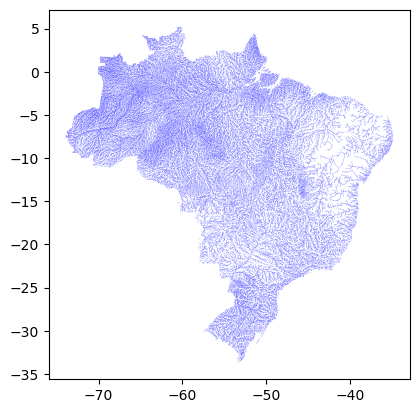

In [4]:
# Data source - https://www.hydrosheds.org/products/hydrorivers
samerica_rivers = gpd.read_parquet("../resources/data/rivers.parquet.gzip")

samerica_rivers.plot(color='blue', lw=0.1)

<AxesSubplot:>

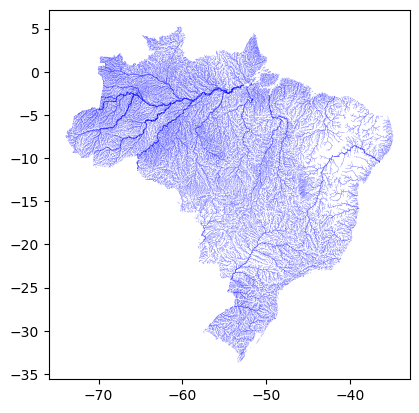

In [5]:
import numpy as np

leftSpan = np.amax(samerica_rivers['DIST_UP_KM']) - np.amin(samerica_rivers['DIST_UP_KM'])
rightSpan = 1 - 0.1
valueScaled = (samerica_rivers['DIST_UP_KM'] - np.amin(samerica_rivers['DIST_UP_KM'])) / leftSpan
samerica_rivers['LW_DIST_UP_KM'] = 0.1 + (valueScaled * rightSpan)

samerica_rivers.plot(edgecolor='face', color='blue', lw=samerica_rivers['LW_DIST_UP_KM'])

<AxesSubplot:>

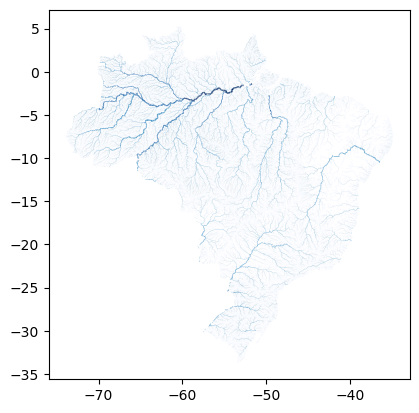

In [6]:
samerica_rivers.plot(column='ORD_FLOW', cmap='Blues_r', lw=samerica_rivers['LW_DIST_UP_KM'])

In [7]:
# Data source - https://www.hydrosheds.org/products/hydrobasins
basins = gpd.read_file("../resources/data/hydrobasins_southam.shp")
print(basins.columns)

Index(['SUB_BAS', 'TO_BAS', 'MAJ_BAS', 'MAJ_NAME', 'SUB_NAME', 'SUB_AREA',
       'MAJ_AREA', 'LEGEND', 'geometry'],
      dtype='object')


## Exercise 

- Generate a map of South American river basins
- Break it down into both major and sub basins

<img src="../resources/assets/basins.png">

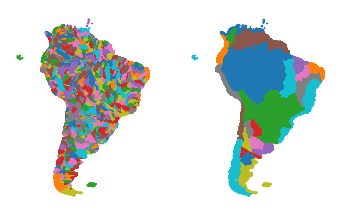

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = plt.subplot(1, 3, 1)
basins.plot(ax=ax1, column='SUB_NAME', edgecolor='face')
ax1.axis('off')

ax2 = plt.subplot(1, 3, 2)
basins.plot(ax=ax2, column='MAJ_NAME', edgecolor='face')
ax2.axis('off')
plt.show()

In [9]:
import pandas as pd

colours_i_like = ['black', 'blue', '#808000', '#483d8b', '#dc143c',
                  '#000080', 'green', '#8b008b', '#ff4500', '#ffa500', '#008856', 
                  '#882D17', '#228B22', '#3cb371', '#875692', '#2f4f4f', '#0000ff',
                  '#ff00ff', '#1e90ff', '#db7093', '#ff1493', 'darkgreen', 
                  '#ee82ee', '#A1CAF1', 'orange']

colors_df = pd.DataFrame({'basin': basins.MAJ_NAME.unique().tolist(), 'colors': colours_i_like})

basins = pd.merge(basins, colors_df, left_on='MAJ_NAME', right_on='basin', how='left')


<AxesSubplot:>

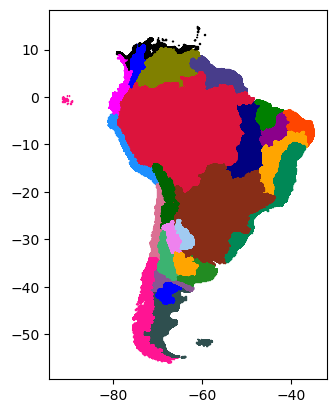

In [10]:
basins.plot(column='MAJ_NAME', edgecolor='face', color=basins['colors'])

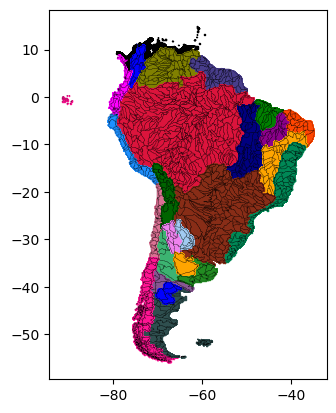

In [11]:
fig, ax = plt.subplots()
basins.plot(ax=ax, column='MAJ_NAME', edgecolor='face', color=basins['colors'])
basins.boundary.plot(ax=ax, color='black', lw=0.1)
plt.show()

## Exercise 

- Plot a map with both rivers and basins.
- Merge the two dataframes into one and plot the rivers, colouring them according to their basin



<img src="../resources/assets/brazil_river_basins.png"  width="400">

In [12]:
rivers_basins = gpd.sjoin(samerica_rivers, basins, predicate="within")

print(rivers_basins.columns)

Index(['DIST_UP_KM', 'geometry', 'ORD_FLOW', 'LW_DIST_UP_KM', 'index_right',
       'SUB_BAS', 'TO_BAS', 'MAJ_BAS', 'MAJ_NAME', 'SUB_NAME', 'SUB_AREA',
       'MAJ_AREA', 'LEGEND', 'basin', 'colors'],
      dtype='object')


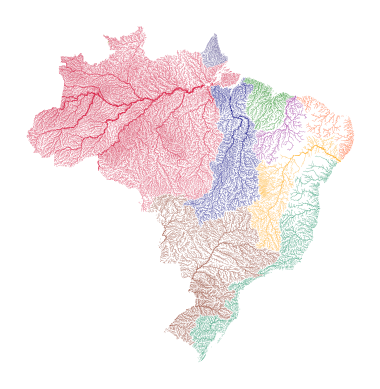

In [13]:
fig, ax = plt.subplots()
rivers_basins.plot(ax=ax, edgecolor='face', color=rivers_basins['colors'], lw=rivers_basins['LW_DIST_UP_KM'])
ax.axis('off')
plt.show()